In [1]:
! pip install ipdb

     |████████████████████████████████| 790 kB 5.3 MB/s 
     |████████████████████████████████| 374 kB 51.2 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=96751737ac1f3c7c11929f601e581a2677dfaadd35c4472139bea896a3641462
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 

In [2]:
!pip install torchmetrics

     |████████████████████████████████| 329 kB 5.2 MB/s 


In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics.functional import f1
import ipdb

In [4]:
!wget -O positive.csv https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0
!wget -O negative.csv https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv?dl=0

--2021-11-26 07:58:15--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2021-11-26 07:58:16--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc30039a90643c83afaa3b04e3a8.dl.dropboxusercontent.com/cd/0/inline/BasVlZsIG8zzmllIDk1xtfs-sZF_GneH291fzdp9hHs25kpj9d83Ws0J1KU2tXLBkTJb0L3vi4HGCPnwCxSV8SktI2Pxl5tpjcBx4JZvcTHJpc0uG31Yi3PZHD094l5ICQkXRfUdWis0wSzbIOpsDTSG/file# [following]
--2021-11-26 07:58:16--  https://uc30039a90643c83afaa3b04e3a8.dl.dropboxusercontent.com/cd/0/inline/BasVlZsIG8zzmllIDk1xtfs-sZF_GneH291fzdp9hHs25kpj9d83Ws0J1KU2tXLBkTJb0L3vi4HGCPnwCxSV8

In [5]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])

In [6]:
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
neg_tweets['tone'] = 0

In [7]:
all_tweets_data = pos_tweets.append(neg_tweets)
print(len(all_tweets_data))

226834


In [8]:
all_tweets_data

,0,1,2,text,tone,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...
111918,425138243257253888,1390195830,Yanch_96,Но не каждый хочет что то исправлять:( http://...,0,0,0,0,1138,32,46,0
111919,425138339503943682,1390195853,tkit_on,скучаю так :-( только @taaannyaaa вправляет мо...,0,0,0,0,4822,38,32,0
111920,425138437684215808,1390195876,ckooker1,"Вот и в школу, в говно это идти уже надо(",0,0,0,1,165,13,16,0
111921,425138490452344832,1390195889,LisaBeroud,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0,0,1,0,2516,187,265,0


Очищаем данные сразу, потому что так проще.

In [9]:
import re

def preprocess(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text

In [10]:
text = '@first_timee хоть я и школота, но поверь, у на.'
preprocess(text)

' first timee хоть я и школота но поверь у на '

In [11]:
all_tweets_data['preprocessed_text'] = all_tweets_data['text'].apply(lambda x: preprocess(x))

In [12]:
all_tweets_data

,0,1,2,text,tone,5,6,7,8,9,10,11,preprocessed_text
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0,first timee хоть я и школота но поверь у нас ...
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2,да все таки он немного похож на него но мой ма...
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0,rt katiacheh ну ты идиотка я испугалась за тебя
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0,rt digger2912 кто то в углу сидит и погибает о...
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1,irina dyshkant вот что значит страшилка d но ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111918,425138243257253888,1390195830,Yanch_96,Но не каждый хочет что то исправлять:( http://...,0,0,0,0,1138,32,46,0,но не каждый хочет что то исправлять URL
111919,425138339503943682,1390195853,tkit_on,скучаю так :-( только @taaannyaaa вправляет мо...,0,0,0,0,4822,38,32,0,скучаю так только taaannyaaa вправляет мозги н...
111920,425138437684215808,1390195876,ckooker1,"Вот и в школу, в говно это идти уже надо(",0,0,0,1,165,13,16,0,вот и в школу в говно это идти уже надо
111921,425138490452344832,1390195889,LisaBeroud,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0,0,1,0,2516,187,265,0,rt them lisaberoud тауриэль не грусти обнял


In [13]:
tweets_data = shuffle(all_tweets_data[['preprocessed_text','tone']])[:100000]

In [14]:
len(tweets_data)

100000

In [15]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.1)

In [16]:
train_sentences[:10]

,preprocessed_text,tone
39390,мама разбудила меня тем что принесла мне в ком...,1
93766,я просто в шоке прошел год а все такие взрослы...,0
97674,rt alonavolar в среду в школу а так еще хочетс...,0
11826,rt vas happing69 helenburst привет я тоже безу...,1
105814,rt kshn русофобы URL,0
89606,rt i am not a gay а мне сука нравились эти усы,0
78284,rt little stuff mary tompson я через раз это п...,1
13952,вчера ездили в ветеринарку слава богу все хорошо,1
66412,ольга 51 москва обычного нормального мужчину д...,0
39373,больше не когда и не за что не буду делать эти...,0


Данную функцию используем для получения словаря по токенам.

In [17]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [18]:
vocab_tokens = Counter()

for text in tweets_data['preprocessed_text']:
    vocab_tokens.update(preprocess(text))
print('всего уникальных токенов:', len(vocab_tokens))

всего уникальных токенов: 152815


In [19]:
filtered_vocab_tokens = set()

for word in vocab_tokens:
    if vocab_tokens[word] > 2:
        filtered_vocab_tokens.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab_tokens))

уникальных токенов, втретившихся больше 2 раз: 34847


In [20]:
#создаем словарь с индексами word2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for word in filtered_vocab_tokens:
    word2id[word] = len(word2id)

In [21]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [22]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['preprocessed_text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index] # токенизируем
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = self.target[index]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.LongTensor(y)
      y = y.type(torch.Tensor).reshape(100,1).to(self.device)
      return padded_ids, y

In [23]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [24]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=100)

In [25]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=100)

In [26]:
test_batch = next(iter(val_iterator))

Класс для первой сети без предобученных эмбеддингов.

In [27]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        #batch_size x filter_count3 x seq_len*
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)

        feature_map_bigrams2 = self.pooling(self.relu(self.bigrams(concat)))
        feature_map_trigrams2 = self.pooling(self.relu(self.trigrams(concat)))
        pooling1 = feature_map_bigrams2.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams2.max(2)[0]
        # batch_size x filter_count3
        concat2 = torch.cat((pooling1, pooling2), 1)
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(concat2) 
        logits = self.out(logits)    
        return logits
      

Обучаем, предсказываем и получаем метрики. Датафрейм со всеми сетями и метриками в конце.

In [28]:
def train(model, iterator, optimizer, criterion, metric):
    print('Training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    epoch_metric = 0
    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        
        batch_metric = metric(preds.round().long(), ys.long(), ignore_index=0)
        epoch_metric += batch_metric
        if not (i + 1) % 50:
            print(f'Train loss: {loss.item()}, Train f1: {batch_metric}')
            #print(f'Train loss: {epoch_loss/i}, Train f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [29]:
def evaluate(model, iterator, criterion, metric):
    print("\nValidating...")
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = metric(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % 50:
              pass
              print(f'Val loss_ev: {loss.item()}, Val f1_ev: {batch_metric}')
                #print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')

    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [30]:
model = CNN(len(word2id), 180)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [31]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, metric=f1)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, metric=f1)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 0
Training...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Train loss: 0.6530159115791321, Train f1: 0.6274510025978088
Train loss: 0.611255943775177, Train f1: 0.6666666865348816
Train loss: 0.582114040851593, Train f1: 0.6603773832321167
Train loss: 0.6109241247177124, Train f1: 0.5428571701049805
Train loss: 0.583979606628418, Train f1: 0.7184466123580933
Train loss: 0.527488648891449, Train f1: 0.7647058963775635
Train loss: 0.5548851490020752, Train f1: 0.6666666269302368
Train loss: 0.5632975101470947, Train f1: 0.7184466123580933
Train loss: 0.5425278544425964, Train f1: 0.6846846342086792
Train loss: 0.6374186277389526, Train f1: 0.6530612111091614
Train loss: 0.5635570287704468, Train f1: 0.7045454382896423
Train loss: 0.60169917345047, Train f1: 0.7047619223594666
Train loss: 0.5253957509994507, Train f1: 0.75
Train loss: 0.5877648591995239, Train f1: 0.6736842393875122
Train loss: 0.5116544961929321, Train f1: 0.7857142090797424
Train loss: 0.5696800947189331, Train f1: 0.6075949668884277
Train loss: 0.5510240197181702, Train f1: 0.

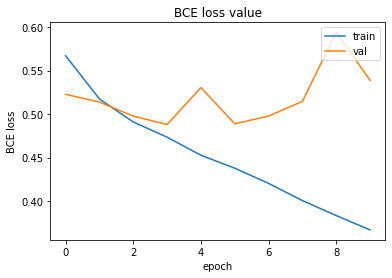

In [32]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

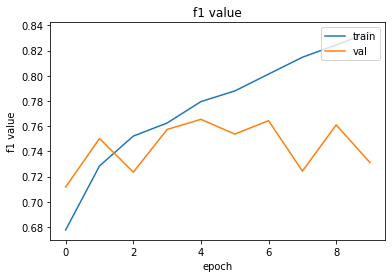

In [33]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [34]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [35]:
fp1, fn1, tp1, tn1 = predict(model, train_iterator)

In [36]:
len(fp1 + fn1 + tp1 + tn1)

90000

In [37]:
a_model1 = (len(tp1)+len(tn1)) / (len(fp1)+len(fn1)+len(tp1)+len(tn1))
p_model1 = len(tp1) / (len(tp1)+len(fp1))
r_model1 = len(tp1) / (len(tp1)+len(fn1))

In [38]:
a_model1, p_model1, r_model1

(0.8636444444444444, 0.9091848534803041, 0.8115432763050974)

Подгружаются fasttext эмбеддинги, обученные на всем корпусе с нуля.

In [39]:
from gensim.models.fasttext import FastText

In [40]:
texts = all_tweets_data.text.apply(preprocess).tolist()

In [41]:
fasttext_model = FastText()
fasttext_model.build_vocab(sentences=texts)
fasttext_model.train(sentences=texts, total_examples=len(texts), epochs=10) 

In [42]:
fasttext_model.wv.most_similar('веселый')

[('весёлый', 0.8847337961196899),
 ('весомый', 0.861290693283081),
 ('тяжелый', 0.8560019135475159),
 ('насыщенный', 0.8494870066642761),
 ('чудесный', 0.8404212594032288),
 ('белый', 0.8387214541435242),
 ('круглый', 0.8376436233520508),
 ('вечный', 0.8327733278274536),
 ('тёплый', 0.8275758028030396),
 ('воскресный', 0.8271726369857788)]

In [43]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = fasttext_model.wv[word]    
    except KeyError:
      count += 1
      weights[i] = np.random.normal(0,0.1,100)

Класс для сети с fasttextом.

In [44]:
class CNN_ft(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)

        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)

        feature_map_bigrams2 = self.pooling(self.relu(self.bigrams(concat)))
        feature_map_trigrams2 = self.pooling(self.relu(self.trigrams(concat)))
        pooling1 = feature_map_bigrams2.max(2)[0] 
        pooling2 = feature_map_trigrams2.max(2)[0]
        concat2 = torch.cat((pooling1, pooling2), 1)

        logits = self.hidden(concat2) 
        logits = self.out(logits)    
        return logits
      

In [45]:
model2 = CNN_ft(len(word2id), 180)
optimizer = optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.BCELoss() # 


model2 = model2.to(DEVICE)
criterion = criterion.to(DEVICE)

In [46]:
losses2 = []
losses_eval2 = []
f1s2 = []
f1s_eval2 = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    f1_value, epoch_loss = train(model2, train_iterator, optimizer, criterion, metric=f1)
    losses2.append(epoch_loss)
    f1s2.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model2, val_iterator, criterion, metric=f1)
    losses_eval2.append(epoch_loss_on_test)
    f1s_eval2.append(f1_value_on_test)


starting Epoch 0
Training...
Train loss: 0.6302128434181213, Train f1: 0.6122449040412903
Train loss: 0.6148042678833008, Train f1: 0.6851851940155029
Train loss: 0.5623751878738403, Train f1: 0.737864077091217
Train loss: 0.5812664031982422, Train f1: 0.7126436829566956
Train loss: 0.5582899451255798, Train f1: 0.6813187003135681
Train loss: 0.48808521032333374, Train f1: 0.699999988079071
Train loss: 0.5269816517829895, Train f1: 0.7256637215614319
Train loss: 0.5650517344474792, Train f1: 0.6428571343421936
Train loss: 0.5395886898040771, Train f1: 0.695652186870575
Train loss: 0.5916128158569336, Train f1: 0.6739130020141602
Train loss: 0.5678256750106812, Train f1: 0.6744186282157898
Train loss: 0.4998936057090759, Train f1: 0.7628865838050842
Train loss: 0.558523416519165, Train f1: 0.7339449524879456
Train loss: 0.5926429033279419, Train f1: 0.5882352590560913
Train loss: 0.4514928460121155, Train f1: 0.778761088848114
Train loss: 0.5697988867759705, Train f1: 0.617283940315246

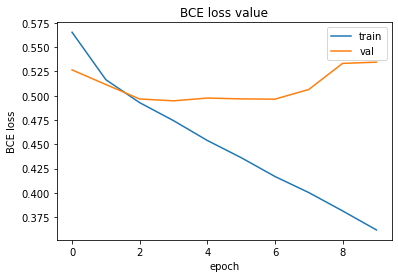

In [47]:
import matplotlib.pyplot as plt
plt.plot(losses2)
plt.plot(losses_eval2)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

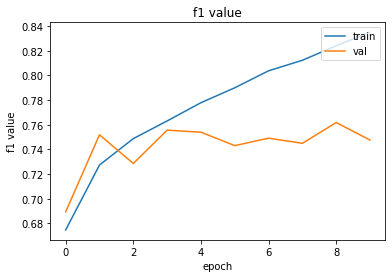

In [48]:
import matplotlib.pyplot as plt
plt.plot(f1s2)
plt.plot(f1s_eval2)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [49]:
fp2, fn2, tp2, tn2 = predict(model2, train_iterator)

In [50]:
len(fp2 + fn2 + tp2 +tn2)

90000

In [51]:
a_model2 = (len(tp2)+len(tn2)) / (len(fp2)+len(fn2)+len(tp2)+len(tn2))
p_model2 = len(tp2) / (len(tp2)+len(fp2))
r_model2 = len(tp2) / (len(tp2)+len(fn2))

In [52]:
a_model2, p_model2, r_model2

(0.8706111111111111, 0.8740397350993377, 0.8695671271385589)

Получаем словарь по символам.

In [53]:
vocab_symbols = Counter()
for element in tweets_data['preprocessed_text']:
  for symbol in element.replace(' ',''):
    vocab_symbols.update(list(symbol))
print('всего уникальных символов:', len(vocab_symbols))

всего уникальных символов: 70


In [54]:
filtered_vocab_symbols = set()

for symbol in vocab_symbols:
    if vocab_symbols[symbol] > 5:
        filtered_vocab_symbols.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab_symbols))

уникальных символов, втретившихся больше 5 раз: 70


In [55]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
symbol2id = {'PAD':0}

for symbol in filtered_vocab_symbols:
    symbol2id[symbol] = len(symbol2id)

In [56]:
#обратный словарь для того, чтобы раскодировать последовательность
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [57]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE


device(type='cuda')

Класс для комбинации эмбеддингов слов и символьных признаков.

In [58]:
class TweetsDataset2(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['preprocessed_text'].values
        self.preprocessed_text = dataset['preprocessed_text'].values
        self.symbol2id = symbol2id
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index] 
        ids_tokens = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        tokens = ''.join(tokens)
        ids_symbols = torch.LongTensor([self.symbol2id[symbol] for symbol in tokens if symbol in self.symbol2id])
        y = self.target[index]
        return ids_tokens, ids_symbols, y


    def collate_fn(self, batch): 
      ids_tokens, ids_symbols, y = list(zip(*batch))
      padded_ids_tokens = pad_sequence(ids_tokens, batch_first=True).to(self.device)
      padded_ids_symbols = pad_sequence(ids_symbols, batch_first=True).to(self.device)
      y = torch.LongTensor(y)
      y = y.type(torch.Tensor).reshape(100,1).to(self.device)
      return padded_ids_tokens, padded_ids_symbols, y

In [59]:
train_dataset2 = TweetsDataset2(train_sentences, word2id, symbol2id, DEVICE)
train_sampler2 = RandomSampler(train_dataset2)
train_iterator2 = DataLoader(train_dataset2, collate_fn = train_dataset2.collate_fn, sampler=train_sampler2, batch_size=100)

Пример батча:

In [60]:
batch = next(iter(train_iterator2))

In [61]:
batch[0][0]

tensor([15393, 15171, 32186, 22485, 31637, 15171, 33326,  8121, 30058,  2241,
        33432,  8121, 13040, 22485, 33432, 22485,  5862,  2241, 34261, 28800,
         5862, 34261, 28800,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0')

In [62]:
batch[1][0]

tensor([62, 53, 52, 59, 14, 53, 49,  9, 54,  5, 45,  9, 69, 59, 45, 59, 32,  5,
        25, 70, 32, 25, 70, 40, 65, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')

In [63]:
batch[2][0]

tensor([1.], device='cuda:0')

In [64]:
val_dataset2 = TweetsDataset2(val_sentences, word2id, symbol2id, DEVICE)
val_sampler2 = SequentialSampler(val_dataset2)
val_iterator2 = DataLoader(val_dataset2, collate_fn = val_dataset2.collate_fn, sampler=val_sampler2, batch_size=100)

Класс для сети с эмбеддингами слов и эмбеддингами символов:

In [65]:
class CNN_2(nn.Module):
    
    def __init__(self, vocab_tokens, vocab_symbols, embedding_dim_tokens, embedding_dim_symbols):
        super().__init__()
        self.embedding_tokens = nn.Embedding(vocab_tokens, embedding_dim_tokens)
        self.embedding_symbols = nn.Embedding(vocab_symbols, embedding_dim_symbols)
        self.bigrams_symbols = nn.Conv1d(in_channels=embedding_dim_symbols, out_channels=100, kernel_size=2, padding='same')
        self.trigrams_symbols = nn.Conv1d(in_channels=embedding_dim_symbols, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=45, out_features=1)
        self.hidden2 = nn.Linear(in_features=366, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, token, symbol):
        embedded_tokens = self.embedding_tokens(token)
        embedded_symbols = self.embedding_symbols(symbol)

        embedded_tokens = embedded_tokens.transpose(1,2)
        embedded_symbols = embedded_symbols.transpose(1,2)

        pooling_tokens = self.pooling(embedded_tokens)
        hidden = self.hidden(pooling_tokens)

        feature_map_bigrams = self.relu(self.bigrams_symbols(embedded_symbols))
        feature_map_trigrams = self.relu(self.trigrams_symbols(embedded_symbols))
        concat1 = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        pooling_symbols = concat1.max(2)[0] 

        hidden = hidden.reshape(100,186)
        concat2 = torch.cat((pooling_symbols, hidden), 1)
        logits = self.hidden2(concat2) 
        logits = self.out(logits)    
        return logits
      

In [66]:
def train(model, iterator, optimizer, criterion, metric):
    print('Training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    epoch_metric = 0
    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (tokens, symbols, ys) in enumerate(iterator):
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(tokens[:, :90], symbols)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        
        batch_metric = metric(preds.round().long(), ys.long(), ignore_index=0)
        epoch_metric += batch_metric
        if not (i + 1) % 50:
            print(f'Train loss: {loss.item()}, Train f1: {batch_metric}')
            #print(f'Train loss: {epoch_loss/i}, Train f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [67]:
def evaluate(model, iterator, criterion, metric):
    print("\nValidating...")
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (tokens, symbols, ys) in enumerate(iterator):
            preds = model(tokens[:, :90], symbols)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = metric(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % 50:
              pass
              print(f'Val loss_ev: {loss.item()}, Val f1_ev: {batch_metric}')
                #print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')

    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [68]:
model3 = CNN_2(len(id2word), len(id2symbol), 186, 8)
optimizer = optim.Adam(model3.parameters(), lr=0.001)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model3 = model3.to(DEVICE)
criterion = criterion.to(DEVICE)

In [69]:
losses3 = []
losses_eval3 = []
f1s3 = []
f1s_eval3 = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    f1_value, epoch_loss = train(model3, train_iterator2, optimizer, criterion, metric=f1)
    losses3.append(epoch_loss)
    f1s3.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model3, val_iterator2, criterion, metric=f1)
    losses_eval3.append(epoch_loss_on_test)
    f1s_eval3.append(f1_value_on_test)


starting Epoch 0
Training...
Train loss: 0.6717464923858643, Train f1: 0.7039999961853027
Train loss: 0.705377995967865, Train f1: 0.5714285969734192
Train loss: 0.6413912177085876, Train f1: 0.6666666865348816
Train loss: 0.5996271967887878, Train f1: 0.695652186870575
Train loss: 0.6530884504318237, Train f1: 0.7462686896324158
Train loss: 0.5919584631919861, Train f1: 0.7719298005104065
Train loss: 0.5644028186798096, Train f1: 0.8163265585899353
Train loss: 0.5900299549102783, Train f1: 0.7199999690055847
Train loss: 0.6348799467086792, Train f1: 0.641509473323822
Train loss: 0.5668496489524841, Train f1: 0.6734693646430969
Train loss: 0.6625627875328064, Train f1: 0.6000000238418579
Train loss: 0.6198035478591919, Train f1: 0.7441860437393188
Train loss: 0.579657793045044, Train f1: 0.5882352590560913
Train loss: 0.5371907949447632, Train f1: 0.6881721019744873
Train loss: 0.6364281177520752, Train f1: 0.6666666865348816
Train loss: 0.5687806010246277, Train f1: 0.685714304447174

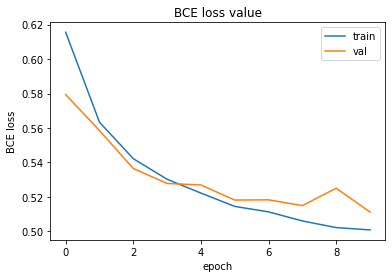

In [70]:
import matplotlib.pyplot as plt
plt.plot(losses3)
plt.plot(losses_eval3)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

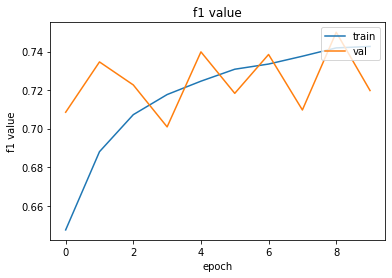

In [71]:
import matplotlib.pyplot as plt
plt.plot(f1s3)
plt.plot(f1s_eval3)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [72]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (tokens, symbols, ys) in enumerate(iterator):   
            preds = model(tokens[:, :90], symbols)  # делаем предсказания на тесте 
            for pred, gold, token, symbol in zip(preds, ys, tokens, symbols):
              text = ' '.join([id2word[int(word)] for word in token if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [73]:
fp3, fn3, tp3, tn3 = predict(model3, train_iterator2)

In [74]:
len(fp3 + fn3 + tp3 +tn3)

90000

In [75]:
a_model3 = (len(tp3)+len(tn3)) / (len(fp3)+len(fn3)+len(tp3)+len(tn3))
p_model3 = len(tp3) / (len(tp3)+len(fp3))
r_model3 = len(tp3) / (len(tp3)+len(fn3))

In [76]:
a_model3, p_model3, r_model3

(0.7530444444444444, 0.7694263981689131, 0.7308984692420881)

In [77]:
a_model1, p_model1, r_model1

(0.8636444444444444, 0.9091848534803041, 0.8115432763050974)

In [78]:
a_model2, p_model2, r_model2

(0.8706111111111111, 0.8740397350993377, 0.8695671271385589)

In [79]:
a_model3, p_model3, r_model3

(0.7530444444444444, 0.7694263981689131, 0.7308984692420881)

Дальше представлены немного улучшенные модели: первая - для сети с подгруженными fasttext эмбеддингами, вторая - для комбинации эмбеддингов токенов и эмбеддингов символов.

In [80]:
class CNN_ft2(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=6, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=8, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=1, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)

        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)

        feature_map_bigrams2 = self.dropout(self.pooling(self.relu(self.bigrams(concat))))
        feature_map_trigrams2 = self.dropout(self.pooling(self.relu(self.trigrams(concat))))
        pooling1 = feature_map_bigrams2.max(2)[0] 
        pooling2 = feature_map_trigrams2.max(2)[0]
        concat2 = torch.cat((pooling1, pooling2), 1)

        logits = self.hidden(concat2) 
        logits = self.out(logits)    
        return logits

Что изменили: kernel_size для биграмм - 6, kernel_size для триграмм - 8, kernel_size для пуллинга - 1.

In [81]:
model2_2 = CNN_ft2(len(word2id), 180)
optimizer = optim.Adam(model2_2.parameters(), lr=0.001)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model2_2 = model2_2.to(DEVICE)
criterion = criterion.to(DEVICE)

In [82]:
def train(model, iterator, optimizer, criterion, metric):
    print('Training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    epoch_metric = 0
    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        
        batch_metric = metric(preds.round().long(), ys.long(), ignore_index=0)
        epoch_metric += batch_metric
        if not (i + 1) % 50:
            print(f'Train loss: {loss.item()}, Train f1: {batch_metric}')
            #print(f'Train loss: {epoch_loss/i}, Train f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [83]:
def evaluate(model, iterator, criterion, metric):
    print("\nValidating...")
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = metric(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % 50:
              pass
              print(f'Val loss_ev: {loss.item()}, Val f1_ev: {batch_metric}')
                #print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')

    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [84]:
losses2_2 = []
losses_eval2_2 = []
f1s2_2 = []
f1s_eval2_2 = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    f1_value, epoch_loss = train(model2_2, train_iterator, optimizer, criterion, metric=f1)
    losses2_2.append(epoch_loss)
    f1s2_2.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model2_2, val_iterator, criterion, metric=f1)
    losses_eval2_2.append(epoch_loss_on_test)
    f1s_eval2_2.append(f1_value_on_test)


starting Epoch 0
Training...
Train loss: 0.6859213709831238, Train f1: 0.6065574288368225
Train loss: 0.6471372842788696, Train f1: 0.6504064798355103
Train loss: 0.6686952710151672, Train f1: 0.5925925970077515
Train loss: 0.5684576630592346, Train f1: 0.723809540271759
Train loss: 0.604199230670929, Train f1: 0.7142857313156128
Train loss: 0.5786007046699524, Train f1: 0.47499996423721313
Train loss: 0.5597385168075562, Train f1: 0.651685357093811
Train loss: 0.5495621562004089, Train f1: 0.7652173638343811
Train loss: 0.5077215433120728, Train f1: 0.7596898674964905
Train loss: 0.6158965826034546, Train f1: 0.6796116828918457
Train loss: 0.5647343993186951, Train f1: 0.651685357093811
Train loss: 0.5803012847900391, Train f1: 0.649350643157959
Train loss: 0.546227216720581, Train f1: 0.6739130020141602
Train loss: 0.6201624274253845, Train f1: 0.6599999666213989
Train loss: 0.5071301460266113, Train f1: 0.7835051417350769
Train loss: 0.5706967115402222, Train f1: 0.6739130616188049

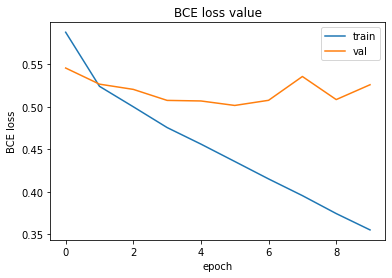

In [85]:
import matplotlib.pyplot as plt
plt.plot(losses2_2)
plt.plot(losses_eval2_2)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

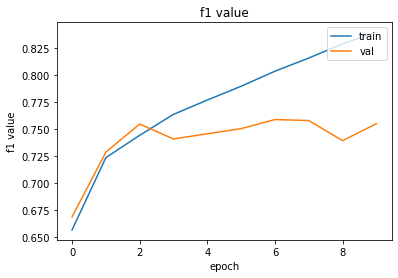

In [86]:
import matplotlib.pyplot as plt
plt.plot(f1s2_2)
plt.plot(f1s_eval2_2)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [87]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [89]:
fp2_2, fn2_2, tp2_2, tn2_2 = predict(model2_2, train_iterator)

In [90]:
a_model2_2 = (len(tp2_2)+len(tn2_2)) / (len(fp2_2)+len(fn2_2)+len(tp2_2)+len(tn2_2))
p_model2_2 = len(tp2_2) / (len(tp2_2)+len(fp2_2))
r_model2_2 = len(tp2_2) / (len(tp2_2)+len(fn2_2))

In [115]:
a_model2_2, p_model2_2, r_model2_2

(0.8903444444444445, 0.8518825479516932, 0.9481035732326005)

In [116]:
a_model2, p_model2, r_model2

(0.8706111111111111, 0.8740397350993377, 0.8695671271385589)

In [93]:
class CNN_ft2(nn.Module):
    
    def __init__(self, vocab_tokens, vocab_symbols, embedding_dim_tokens, embedding_dim_symbols):
        super().__init__()
        self.embedding_tokens = nn.Embedding(vocab_tokens, embedding_dim_tokens)
        self.embedding_symbols = nn.Embedding(vocab_symbols, embedding_dim_symbols)
        self.bigrams_symbols = nn.Conv1d(in_channels=embedding_dim_symbols, out_channels=60, kernel_size=14, padding='same')
        self.trigrams_symbols = nn.Conv1d(in_channels=embedding_dim_symbols, out_channels=80, kernel_size=6, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=1, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=45, out_features=1)
        self.hidden2 = nn.Linear(in_features=326, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, token, symbol):
        embedded_tokens = self.embedding_tokens(token)
        embedded_symbols = self.embedding_symbols(symbol)

        embedded_tokens = embedded_tokens.transpose(1,2)
        embedded_symbols = embedded_symbols.transpose(1,2)

        pooling_tokens = self.pooling(embedded_tokens)
        hidden = self.hidden(pooling_tokens)

        feature_map_bigrams = self.relu(self.bigrams_symbols(embedded_symbols))
        feature_map_trigrams = self.relu(self.trigrams_symbols(embedded_symbols))
        concat1 = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        pooling_symbols = concat1.max(2)[0] 

        hidden = hidden.reshape(100,186)

        concat2 = torch.cat((pooling_symbols, hidden), 1)
        logits = self.hidden2(concat2) 
        logits = self.out(logits)    
        return logits


Что изменили: kernel_size для биграмм - 14, kernel_size для триграмм - 6, kernel_size для пуллинга - 1,  изменен оптимизатор на NAdam. 
Также была попытка сделатьт фильтры для токенов, а не только для символов, однако к улучшению это не привело.

In [94]:
model3_2 = CNN_ft2(len(id2word), len(id2symbol), 186, 8)
optimizer = optim.NAdam(model3_2.parameters(), lr=0.002)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model3_2 = model3_2.to(DEVICE)
criterion = criterion.to(DEVICE)

In [95]:
def train(model, iterator, optimizer, criterion, metric):
    print('Training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    epoch_metric = 0
    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (tokens, symbols, ys) in enumerate(iterator):
       #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(tokens[:, :90], symbols)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        
        batch_metric = metric(preds.round().long(), ys.long(), ignore_index=0)
        epoch_metric += batch_metric
        if not (i + 1) % 50:
            print(f'Train loss: {loss.item()}, Train f1: {batch_metric}')
            #print(f'Train loss: {epoch_loss/i}, Train f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [96]:
def evaluate(model, iterator, criterion, metric):
    print("\nValidating...")
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (tokens, symbols, ys) in enumerate(iterator):
            preds = model(tokens[:, :90], symbols)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = metric(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % 50:
              pass
              print(f'Val loss_ev: {loss.item()}, Val f1_ev: {batch_metric}')
                #print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')

    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [97]:
losses3_2 = []
losses_eval3_2 = []
f1s3_2 = []
f1s_eval3_2 = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    f1_value, epoch_loss = train(model3_2, train_iterator2, optimizer, criterion, metric=f1)
    losses3_2.append(epoch_loss)
    f1s3_2.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model3_2, val_iterator2, criterion, metric=f1)
    losses_eval3_2.append(epoch_loss_on_test)
    f1s_eval3_2.append(f1_value_on_test)


starting Epoch 0
Training...
Train loss: 0.6849169135093689, Train f1: 0.594059407711029
Train loss: 0.6344932913780212, Train f1: 0.5979381799697876
Train loss: 0.6411176919937134, Train f1: 0.6666666865348816
Train loss: 0.6639078855514526, Train f1: 0.5517240762710571
Train loss: 0.5513006448745728, Train f1: 0.7179486751556396
Train loss: 0.5750533938407898, Train f1: 0.6526315808296204
Train loss: 0.555837094783783, Train f1: 0.658227801322937
Train loss: 0.55118328332901, Train f1: 0.6585365533828735
Train loss: 0.5641307830810547, Train f1: 0.6964285969734192
Train loss: 0.5352452993392944, Train f1: 0.8188976645469666
Train loss: 0.5361543297767639, Train f1: 0.7768595218658447
Train loss: 0.5683374404907227, Train f1: 0.6190476417541504
Train loss: 0.5342312455177307, Train f1: 0.695652186870575
Train loss: 0.5455847978591919, Train f1: 0.7422680854797363
Train loss: 0.5497470498085022, Train f1: 0.7716535925865173
Train loss: 0.49835479259490967, Train f1: 0.7200000286102295

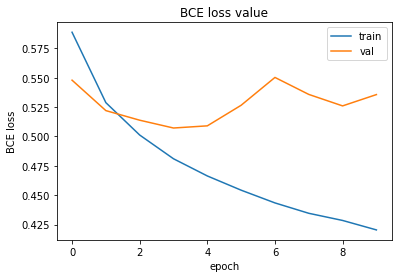

In [98]:
import matplotlib.pyplot as plt
plt.plot(losses3_2)
plt.plot(losses_eval3_2)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

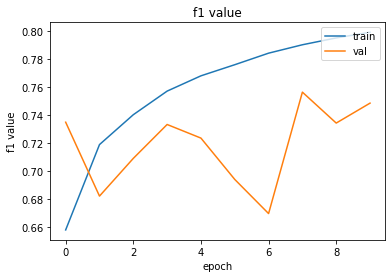

In [99]:
import matplotlib.pyplot as plt
plt.plot(f1s3_2)
plt.plot(f1s_eval3_2)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [100]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (tokens, symbols, ys) in enumerate(iterator):   
            preds = model(tokens[:, :90], symbols)  # делаем предсказания на тесте 
            for pred, gold, token, symbol in zip(preds, ys, tokens, symbols):
              text = ' '.join([id2word[int(word)] for word in token if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [101]:
fp3_2, fn3_2, tp3_2, tn3_2 = predict(model3_2, train_iterator2)

In [102]:
a_model3_2 = (len(tp3_2)+len(tn3_2)) / (len(fp3_2)+len(fn3_2)+len(tp3_2)+len(tn3_2))
p_model3_2 = len(tp3_2) / (len(tp3_2)+len(fp3_2))
r_model3_2 = len(tp3_2) / (len(tp3_2)+len(fn3_2))

In [103]:
a_model3_2, p_model3_2, r_model3_2

(0.8199666666666666, 0.7921314741035856, 0.8733226451145323)

In [104]:
a_model3, p_model3, r_model3

(0.7530444444444444, 0.7694263981689131, 0.7308984692420881)

Сравним метрики на всех моделях:

In [105]:
a_model1, p_model1, r_model1

(0.8636444444444444, 0.9091848534803041, 0.8115432763050974)

In [106]:
a_model2, p_model2, r_model2

(0.8706111111111111, 0.8740397350993377, 0.8695671271385589)

In [107]:
a_model2_2, p_model2_2, r_model2_2

(0.8903444444444445, 0.8518825479516932, 0.9481035732326005)

In [108]:
a_model3, p_model3, r_model3

(0.7530444444444444, 0.7694263981689131, 0.7308984692420881)

In [109]:
a_model3_2, p_model3_2, r_model3_2

(0.8199666666666666, 0.7921314741035856, 0.8733226451145323)

In [110]:
accuracy = [a_model1, a_model2, a_model3, a_model2_2, a_model3_2]
precision = [p_model1, p_model2, p_model3, p_model2_2, p_model3_2]
recall = [r_model1, r_model2, r_model3, r_model2_2, r_model3_2]

In [111]:
df = pd.DataFrame({'model': ['CNN', 'CNN_Fasttext', 'CNN_symbols_tokens','CNN_Fasttext2','CNN_symbols_tokens2' ], 'Accuracy': accuracy, 'Precision':precision, 'Recall':recall})

In [112]:
df

,model,Accuracy,Precision,Recall
0,CNN,0.863644,0.909185,0.811543
1,CNN_Fasttext,0.870611,0.874040,0.869567
2,CNN_symbols_tokens,0.753044,0.769426,0.730898
3,CNN_Fasttext2,0.890344,0.851883,0.948104
4,CNN_symbols_tokens2,0.819967,0.792131,0.873323


К сожалению, текст представлен с пробелами между буквами.

In [119]:
print('что правильно предсказываем:')

что правильно предсказываем: ['с а м а я с ч а с т л и в а я с п а с и б о р о д н ы е ч т о в ы с о м н о й э т о о г р о м н о е с ч а с т ь е и м е т ь т а к и х к а к в ы', 'b a p b a n g y o n g g u k д а п о ж а л у й с т а м ы р а д ы е с л и в ы р а д ы п р и е з ж а й к н а м в р о с с и ю', 't a y a s c h m i d t ч т о ч т ч о ч т о ч т о ч т о ч т ч о т ч о т ч т ч о ч т о ч т ч о т ч о d', 'в о о б щ е л ю б л ю т е к с т у р у и с н и м а т ь в с я к у ю х е р н ю', 'g r a n d i s o g n a t o r e а х а х а х а х а х п р о с т о к р а с а в е ц d н у к о н е ч н о й о р к и к о у л в т е г о д ы п р о с т о з а ж и г а л и', 'с е г о д н я н а к а з а л 2 р а з а n o i s e 1 3 в f i f a э т о у с п е х', 'l o k t i n a c т ы д о л ж н а б ы л а в с е г д а б ы т ь н а ч е к у к а к б а т ь к а н е з а б у д ь у п о м я н у т ь ч т о е щ е щ е к о т а л а', 'e c h e r i e c g д а н е т п р о с т о ч е л о в е к г о в о р и т ч т о о н и д и о т а в р е з у л ь т а т е и д и 

In [126]:
tp3[:10]

['с а м а я с ч а с т л и в а я с п а с и б о р о д н ы е ч т о в ы с о м н о й э т о о г р о м н о е с ч а с т ь е и м е т ь т а к и х к а к в ы',
 'b a p b a n g y o n g g u k д а п о ж а л у й с т а м ы р а д ы е с л и в ы р а д ы п р и е з ж а й к н а м в р о с с и ю',
 't a y a s c h m i d t ч т о ч т ч о ч т о ч т о ч т о ч т ч о т ч о т ч т ч о ч т о ч т ч о т ч о d',
 'в о о б щ е л ю б л ю т е к с т у р у и с н и м а т ь в с я к у ю х е р н ю',
 'g r a n d i s o g n a t o r e а х а х а х а х а х п р о с т о к р а с а в е ц d н у к о н е ч н о й о р к и к о у л в т е г о д ы п р о с т о з а ж и г а л и',
 'с е г о д н я н а к а з а л 2 р а з а n o i s e 1 3 в f i f a э т о у с п е х',
 'l o k t i n a c т ы д о л ж н а б ы л а в с е г д а б ы т ь н а ч е к у к а к б а т ь к а н е з а б у д ь у п о м я н у т ь ч т о е щ е щ е к о т а л а',
 'e c h e r i e c g д а н е т п р о с т о ч е л о в е к г о в о р и т ч т о о н и д и о т а в р е з у л ь т а т е и д и о т а м и о к а з ы в 

In [127]:
print('что неправильно:')

что неправильно:


In [122]:
fn3[:10]

['h e l l s p i t e п р о ч и т а л а с п а л ь ц е м',
 'н а п е ч а т а л а т о л ь к о о д н у с т р а н и ц у щ а с с д е л а ю т в о ю м а т ь 2 6 ш р и ф т и н е б у д у п а р и т с я',
 'н а д е ю с ь в р е м я п р и к л ю ч е н и й м н е н а с т р о е н и е п о д н и м е т',
 'п о р а б о т а л и н е п л о х о ю л и а н н а п р и е х а л а с к и п р а п р и в е з л а н а м п о д а р о ч к и',
 'я ж и в у в ч е р а ч т о б ы н е п о в т о р я т ь с е г о д н я ш н и х о ш и б о к',
 'd e p u t a t l i s к о н е ч н о ж и в а я т о л ь к о с о с н а в ж и з н и и т а к с т о л ь к о п о д м е н ы и м у л я ж а р а з в г о д у х о ч е т с я н а с т о я щ е г о л ю б и м ы х л ю д е й д р у з е й е л к и',
 'e v g e n b u l a n k i n е б а н ы й н а с о с п у т а ю к о н е ч н о й о р к а р а й т б л я т ь',
 'о к а з ы в а е т с я е с т ь г р у п п а i n m y h u m b l e o p i n i o n i m h o',
 'в о т н е т б ы о б н а д е ж и т ь ч е м н и т ь т ь ф у у ж е н а э т о т м т с д е 

Хорошо предсказываются те твиты, в которых точно есть слова с положительной окраской, плохо предсказываются те твиты, где на самом деле не очень понятно6 положительный он или нет. Возможно, удобно было бы сделать третий класс, в который входили бы твиты, которые нельзя отнести ни к положительным, ни к отрицательным.